In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# PIL to open & manipulate images
from PIL import Image, ImageOps, ImageChops

# for messages in loops
from IPython.display import clear_output

# to save arrays
import h5py

# for folder-timestamp
from datetime import datetime

# for train/test split
from sklearn.model_selection import train_test_split
# for one-hot encoding
from sklearn.preprocessing import LabelBinarizer
# for class weights
from sklearn.utils import class_weight
# for model evaluation
from sklearn.metrics import confusion_matrix, classification_report
# for efficient loops
import itertools

# keras
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils import HDF5Matrix
from tensorflow.python.keras.models import Sequential, load_model
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, \
    Dropout, Lambda, Activation, BatchNormalization
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import callbacks

In [2]:
def crps(y_true, y_pred):
    diff = (y_true - y_pred)
    diff_2 = K.square(diff)
    loss = K.mean(diff_2)
    return loss

In [4]:
img_val = HDF5Matrix('/cluster/home/rohrbjan/joint_scoring/img_val_regression.h5', 'img_val_regression')
img_val.shape

(9931, 150, 150, 1)

In [6]:
model = load_model("/cluster/home/rohrbjan/joint_scoring/models/20171128_000703.h5", custom_objects={'crps': crps})

In [7]:
# images need to be rgb (shape (150, 150, 3))
from IPython.display import clear_output
from PIL import Image

img_val_rgb = []

for i, img in enumerate(img_val):
    if i % 1000 == 0:
        clear_output()
        print("Converting validation images to RGB, {0:.2f} % finished".format(i/72625*100))
    im = Image.fromarray((img.squeeze()).astype("int16"))
    im = im.convert("RGB")
    dat = np.array(im)
    img_val_rgb.append(dat)

Converting validation images to RGB, 12.39 % finished


In [8]:
img_val_rgb = np.array(img_val_rgb)

In [9]:
from tensorflow.python.keras.applications.inception_v3 import preprocess_input

img_val_rgb = [preprocess_input(x) for x in img_val_rgb.astype("float32")]

In [10]:
img_val_rgb = np.array(img_val_rgb)

In [11]:
p = model.predict(img_val_rgb)
print(p.shape)

pred = np.zeros(p.shape[0])
print(pred.shape)

for i in range(p.shape[0]):
    pred[i] = sum(1 - p[i])

(9931, 101)
(9931,)


In [14]:
labels_val_reg = HDF5Matrix('/cluster/home/rohrbjan/joint_scoring/labels_val_regression.h5', 'labels_val_regression')

In [29]:
def cdf(label):
    arr = np.zeros(101)
    arr[int(label):] = 1
    return arr

labels_val = [cdf(x) for x in labels_val_reg]
labels_val = np.array(labels_val)

In [30]:
model.evaluate(x=img_val_rgb, y=labels_val)
# [loss, metric]

9888/9931 [============================>.] - ETA: 0s

[0.030922507410136586, 0.036497402681140378]

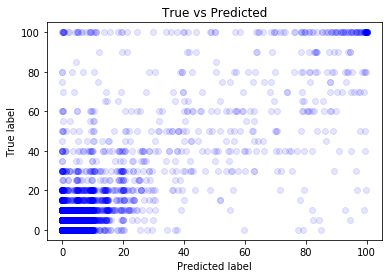

In [15]:
plt.title("True vs Predicted")
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.scatter(x=pred, y=labels_val_reg, color="blue", alpha=0.1)

plt.show()

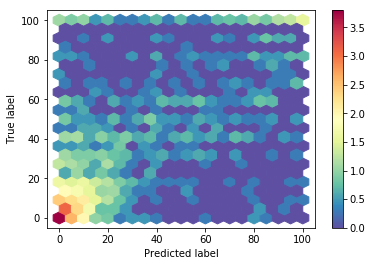

In [17]:
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.hexbin(x=pred, y=labels_val_reg, gridsize=20, bins='log', cmap=plt.cm.Spectral_r)
plt.colorbar()

plt.show()

In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [19]:
mean_absolute_error(y_true=labels_val_reg, y_pred=pred)

3.4959410941981317

In [20]:
mean_squared_error(y_true=labels_val_reg, y_pred=pred)

97.586130152553878

In [21]:
r2_score(y_true=labels_val_reg, y_pred=pred)

0.62553181393857837